<a href="https://colab.research.google.com/github/IdaCy/mech-typo-detect/blob/main/typo_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mechanistic Interpretability of Typo vs. Clean Prompts
**Author**: Ida Caspary (Imperial College London)

## Introduction

The purpose of this notebook is to explore mechanistic interpretability of a large language model when it is fed prompts with small typographical errors. We want to see:
- How hidden layers and attention distributions are affected by a single typo in the prompt.
- How differences in activation patterns might shed light on how the model handles (or mis-handles) these noise inputs.

We have **5,000 pairs** of prompts: one “clean” version and one **“typo”** version where exactly one token has been altered. For each prompt pair, we extracted from HPC runs:
- Hidden states at layers `[0, 1, 2, 3, 4, 5, 6, 7, 10, 15, 20, 25, 30, 31]`.
- Final logits & probabilities from layer 31.
- Predictions, tokenization.

We also have **difference files** (clean vs. typo) stored in `analyses_results/differences/activations_*.pt`.

In this notebook, we will:
1. Load these `.pt` files and inspect the differences.
2. Perform PCA on the activation differences to see if there's a low-dimensional “typo signal.”
3. Look at correlation, variance, and which neurons shift the most under typos.
4. Explore ideas for analyzing mechanistic reasons behind these differences.

**Note:** Some surprising initial results (e.g., extremely high explained variance in the first principal component for certain layers) indicate that the “typo difference” might be dominated by a few outlier neurons. We will investigate this further.


## Notebook Setup & Dependencies

Below, we install or import all the necessary libraries. And, get the modules from the GitHub repository.


In [ ]:
# Check Python version (optional):
import sys
print("Python version:", sys.version)

# Get installations
!pip install --quiet torch numpy matplotlib scikit-learn
!pip install --quiet huggingface_hub transformers

# Clone and get into directory from github
!git clone https://github.com/IdaCy/mech-typo-detect.git
%cd mech-typo-detect

import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# If you want to check GPU usage:
import torch
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

Python version: 3.11.11 (main, Dec  4 2024, 08:55:07) [GCC 11.4.0]
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 46.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 39.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 56.6 MB/s eta 0:00:00
Cloning into 'mech-typo-detect'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compr

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

os.environ["HF_API_TOKEN"] = "XXX"

Mounted at /content/drive


## Running Inference on Clean vs. Typo Prompts

Now that we've set up the environment and verified our imports, we can move on to the actual inference step. In our repository, there's a script inside `scripts/mistral/` that performs inference on the model, generating hidden states, logits, etc.

In [ ]:
!python scripts/mistral/inference.py

## Step 1: Compute Differences Between Clean & Typo
This script, `1_diffs_compute.py`, reads combined activation files (in `big_extractions`) that contain both the “clean” and “typo” data. It then computes the differences (clean minus typo) for each relevant key (hidden states, attention scores, logits, etc.) and saves them in `analyses_results/big_differences`.

**Key Points**:
- Input directory: `extractions`
- Output directory: `analyses_results/differences`
- Loops through each `.pt` file and subtracts `typo` from `clean`.

In [ ]:
!python scripts/analyses/1_diffs_compute.py

## Step 2: Perform PCA on the Differences
`2_pca_pc1.py` takes the difference files from `analyses_results/differences` (or wherever you placed them) and:
1. Loads each difference file in parallel.
2. Extracts the difference vectors from each layer.
3. Runs PCA (with 10 components) and stores the PCA results and the first principal component (PC1) vector.
4. Plots how much variance PC1 explains per layer.

**Key Points**:
- Input directory: `analyses_results/differences`
- Output directory: `analyses_results/PCA_PC1` (for both numeric `.pt` files and a `pca_plot.png`).
- You can control `max_samples` for memory use.


In [ ]:
!python scripts/analyses/2_pca_pc1.py

In [ ]:
!git clone https://github.com/IdaCy/mech-typo-detect.git
%cd mech-typo-detect

Cloning into 'mech-typo-detect'...
remote: Enumerating objects: 111, done.
remote: Counting objects: 100% (111/111), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 111 (delta 37), reused 102 (delta 28), pack-reused 0 (from 0)
Receiving objects: 100% (111/111), 1.77 MiB | 22.99 MiB/s, done.
Resolving deltas: 100% (37/37), done.
/content/mech-typo-detect/mech-typo-detect


## Step 3: Check PCA Results
Finally, `3_pca_check.py` will:
1. Load the PCA results (`layer_pca_results.pt`) and PC1 vectors (`layer_pc1_vectors.pt`).
2. Print a summary of each layer’s top 10 explained variance ratios.
3. Show the shape of the PC1 vectors (and optionally prints a few elements).
4. Create a quick plot of PC1 explained variance ratio across layers.

**Key Points**:
- Reads from `analyses_results/PCA_PC1/layer_pca_results.pt` and `layer_pc1_vectors.pt`.
- Plots the explained variance for PC1 per layer.
- Displays the figure in the notebook.

=== PCA Results Summary ===
Type of PCA results: <class 'dict'>
Layers found: ['layer_0', 'layer_1', 'layer_2', 'layer_3', 'layer_4', 'layer_5', 'layer_6', 'layer_7', 'layer_10', 'layer_15', 'layer_20', 'layer_25', 'layer_30', 'layer_31']
Total layers: 14

Layer layer_0:
  Explained variance ratios (top 10): [0.04447212 0.02568739 0.02283133 0.02011898 0.01450857 0.01263586
 0.01228408 0.01107478 0.00986411 0.00853996]

Layer layer_1:
  Explained variance ratios (top 10): [9.6497720e-01 1.6532047e-03 1.2876085e-03 9.9266914e-04 7.5394358e-04
 6.6311809e-04 5.3007394e-04 5.0650304e-04 4.4242959e-04 4.3132415e-04]

Layer layer_2:
  Explained variance ratios (top 10): [9.9996758e-01 3.8787971e-06 2.6100363e-06 1.1601883e-06 1.0431118e-06
 8.0880022e-07 7.1690289e-07 6.0613166e-07 5.5054562e-07 4.7129390e-07]

Layer layer_3:
  Explained variance ratios (top 10): [9.9990422e-01 6.5014933e-06 3.7147388e-06 3.3264946e-06 2.2307752e-06
 2.0255482e-06 1.7475334e-06 1.5025255e-06 1.2251045e-06 1

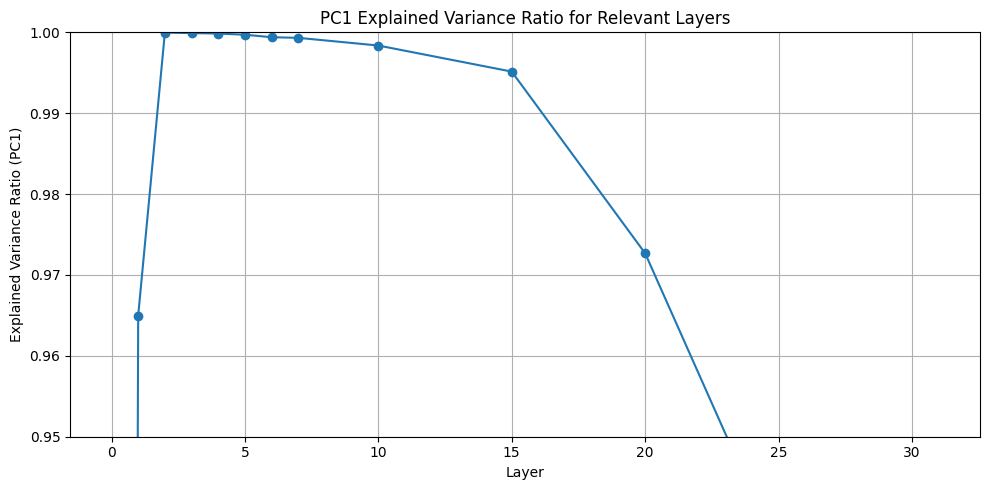

<Figure size 640x480 with 0 Axes>

In [ ]:
%run scripts/analyses/3_pca_check.py